# The latent cognitive structures of social networks code tutorial
This notebook was written to accompany the manuscript _The latent cognitive structures of social networks_ (Aguiar, Ugander 2023). Here, we introduce and explain code from the work and document finding the NNTuck of the advice CSS from Krackhardt (1987). 

This notebook depends on `numpy`, `tensorly`, `sklearn`, and `matplotlib`. When sweeping over parameters $K$ and $C$ in NNTuck it is most efficient to run the sweep in parallel, which depends on `joblib` and on `os` to make sure the parallel runs don't use too much CPU. In this tutorial we only sweep over one possible combination of parameters $(K,C)$, but the code is still written in parallel to easily adapt for a more comprehensive sweep. Specific version numbers for which this code runs are in the readme.

The NNTuck multiplicative updates are in `NNTucktools.py` along with definitions of KL-divergence and log-likelihood. The multiplicative updates for the Social-Cognitive Agreement NNTuck are in `NNTucktools_SC_Agreement.py`.

Masking tools are in `masking_tools_*_chunks.py` where `*` is replaced by either `directed` or `undirected` depending on the network type. The masking functions in these files mask the adjacency tensor using the rules of the tubular link prediction task. Formal definitions of the task can be found in the main manuscript. 
These files also include definitions for `Per_alpha`, `Per_alpha_c`, and `Per_alpha_ones`. Each of these definitions assists in the parallel sweep over $K$ and $C$ when estimating the NNTuck for the network, and does so for an NNTuck with $C=\alpha$, $\boldsymbol{Y} = \boldsymbol{I}$, and $\boldsymbol{Y} = [1, \dots, 1]^\top$, respectively, each corresponding to a deflated NNTuck of dimension $\alpha$, a constrained NNTuck with a layer-independence assumption, and a constrained NNTuck with a layer-redundance assumption. Again, for more information on each of these model assumptions see the main manuscript.

In this notebook we: visualize the Advice CSS from Krackhardt (1987); visualize the hyperparameter sweep over $K$ and $C$; estimate an NNTuck by using multiple random initializations for the multiplicative updates algorithm; perform relevant likelihood ratio tests (both standard and Universal Inference (Wasserman et al., 2021); visualize and interpret the social and cognitive spaces in the Advice CSS from Krackhardt (1987); rewrite the core tensor in the basis of three individuals in the network, and visualize this relative cognitive space.

Please email me at `izzya@stanford.edu` with _any_ questions at all about this tutorial or the code associated with it!

### Import libraries and external definitions

In [197]:
import NNTucktools  #this .py file contains function definitions for non_negative_tucker with KL loss,
                    # as well as for MULTITENSOR's EM updates
import numpy as np
from NNTucktools import non_negative_tucker, non_negative_tucker_SCA, non_negative_tucker_ones, KL_D, max_like, GenerateSBM, Y_interp
import tensorly as tl
from sklearn.metrics import roc_auc_score
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.base import unfold
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from matplotlib.ticker import MaxNLocator
from tensorly.tenalg import mode_dot
import scipy
import copy
import pyreadr
import networkx as nx
import ast


ImportError: cannot import name 'non_negative_tucker_SCA' from 'NNTucktools' (/Users/izabelaguiar/Library/CloudStorage/Dropbox/RESEARCH/CSS/NNTucktools.py)

### Load the adjacency tensor
For this code tutorial we focus on the \acs{css} dataset from [Krackhardt (1987)](https://bebr.ufl.edu/sites/default/files/Cognitive%20Social%20Strucutres.pdf), wherein $N=21$ managers in a high tech firm were asked to report on their perceptions of the _advice network_. Specifically, each person was asked who approached whom for work-related advice. We interpret each persons responses as a layer of a multilayer network, representing the CSS as an $21 \times 21 \times 21$ adjacency tensor $\mathcal{A}$, where each layer is represented as a frontal slice of the tensor.

In [2]:
from numpy import genfromtxt
krack = np.zeros((21,21,21))
for j in range(1,22):
    p = str(j)
    filename = 'krackhardt_data/krack_' + p + '.csv'
    krack_temp = genfromtxt(filename, delimiter=',')
    krack[j-1, :, :] = krack_temp

### Visualize the structure of the company
We begin by showing the structure and available metadata about the company and individuals represented by this CSS. 

In [3]:
kracknets = pyreadr.read_r('kracknets.rda')

depts = np.array(kracknets['attributes']['DEPT'])
tenure = np.array(kracknets['attributes']['TENURE'])
age = np.array(kracknets['attributes']['AGE'])
level = np.array(kracknets['attributes']['LEVEL'])

kracknetrepnp = np.array(kracknets['reports_to_data_frame'])
kracknetrepnp[:, (0,1)] = kracknetrepnp[:, (0,1)] - 1

kracknet_report_adj = np.zeros((21,21))
for l in range(441):
    i = kracknetrepnp[l][0]
    j = kracknetrepnp[l][1]
    k = kracknetrepnp[l][2]
    kracknet_report_adj[i,j] = k

In [165]:
posrep = {0: np.array([ 0.36704917, -0.87309407]),
 1: np.array([ 0.25198734, -0.53055533]),
 2: np.array([-0.89587249, -0.19925205]),
 3: np.array([ 0.51139739, -0.70950406]),
 4: np.array([-0.53020225, -0.28623758]),
 5: np.array([0.95174082, 0.30093429]),
 6: np.array([0.08891742, 0.01561021]),
 7: np.array([0.78723949, 0.42963133]),
 8: np.array([-0.8475622 ,  0.10490396]),
 9: np.array([0.23667186, 0.81803294]),
 10: np.array([0.00744397, 0.83504216]),
 11: np.array([1.        , 0.10694856]),
 12: np.array([-0.83146648,  0.27821425]),
 13: np.array([-0.58488428, -0.00903106]),
 14: np.array([-0.59108917,  0.28617441]),
 15: np.array([ 0.14753465, -0.83684102]),
 16: np.array([ 0.87820785, -0.06696584]),
 17: np.array([0.10584601, 0.51693399]),
 18: np.array([-0.74074995, -0.30333086]),
 19: np.array([-0.9704296 , -0.01727718]),
 20: np.array([0.65822045, 0.13966293])}
#nx.spring_layout(krack_Network_report, k=0.1)#, pos = {17: np.array([])})

Text(-1.5, -0.6, 'reports to')

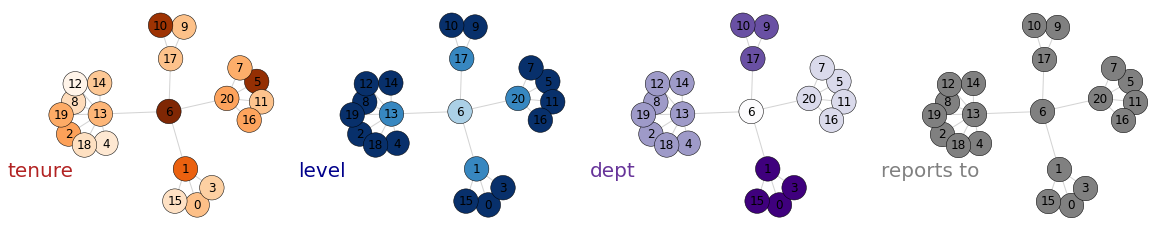

In [166]:
krack_Network_report = nx.from_numpy_array(kracknet_report_adj)
f, axis = plt.subplots(1,4)
f.set_figheight(4)
f.set_figwidth(20)
colors_level = ['c'] * len(kracknet_report_adj)
colors_dept = ['c'] * len(kracknet_report_adj)
colors_tenure = ['c'] * len(kracknet_report_adj)
cmapOne=plt.get_cmap('Oranges')
cmapTwo=plt.get_cmap('Purples')
cmapThree=plt.get_cmap('Blues')
depts_norm = depts/4
tenure_norm = tenure/30
level_norm = level/3
for i in range(len(kracknet_report_adj)):
    colors_level[i] = cmapThree(level_norm[i])
    colors_tenure[i] = cmapOne(tenure_norm[i])
    colors_dept[i] = cmapTwo(depts_norm[i])
nx.draw(krack_Network_report, posrep,  ax=axis[1], node_color=colors_level, node_size=600, edge_color='lightgrey', with_labels=True)
axis[1].collections[0].set_edgecolor("k") 
axis[1].collections[0].set_linewidths(0.5)

nx.draw(krack_Network_report, posrep,  ax=axis[0], node_color=colors_tenure, node_size=600, edge_color='lightgrey', with_labels=True)
axis[0].collections[0].set_edgecolor("k") 
axis[0].collections[0].set_linewidths(0.5)

nx.draw(krack_Network_report, posrep,  ax=axis[2], node_color=colors_dept, node_size=600, edge_color='lightgrey', with_labels=True)
axis[2].collections[0].set_edgecolor("k") 
axis[2].collections[0].set_linewidths(0.5)

nx.draw(krack_Network_report, posrep,  ax=axis[3], node_color='grey', node_size=600, edge_color='lightgrey', with_labels=True)
axis[3].collections[0].set_edgecolor("k") 
axis[3].collections[0].set_linewidths(0.5)

axis[0].text(-1.5, -0.6, 'tenure', fontsize = 20, c = 'firebrick')
axis[2].text(-1.5, -0.6, 'dept', fontsize = 20, c = 'rebeccapurple')
axis[1].text(-1.5, -0.6, 'level', fontsize = 20, c = 'darkblue')
axis[3].text(-1.5, -0.6, 'reports to', fontsize = 20, c = 'grey')

## Visualise the CSS
To visualize this multilayer network, we show each person's perception of the advice network in a separate plot, where the first plot corresponds to person 1's perception, the second to person 2's, and so on for all 21 people.

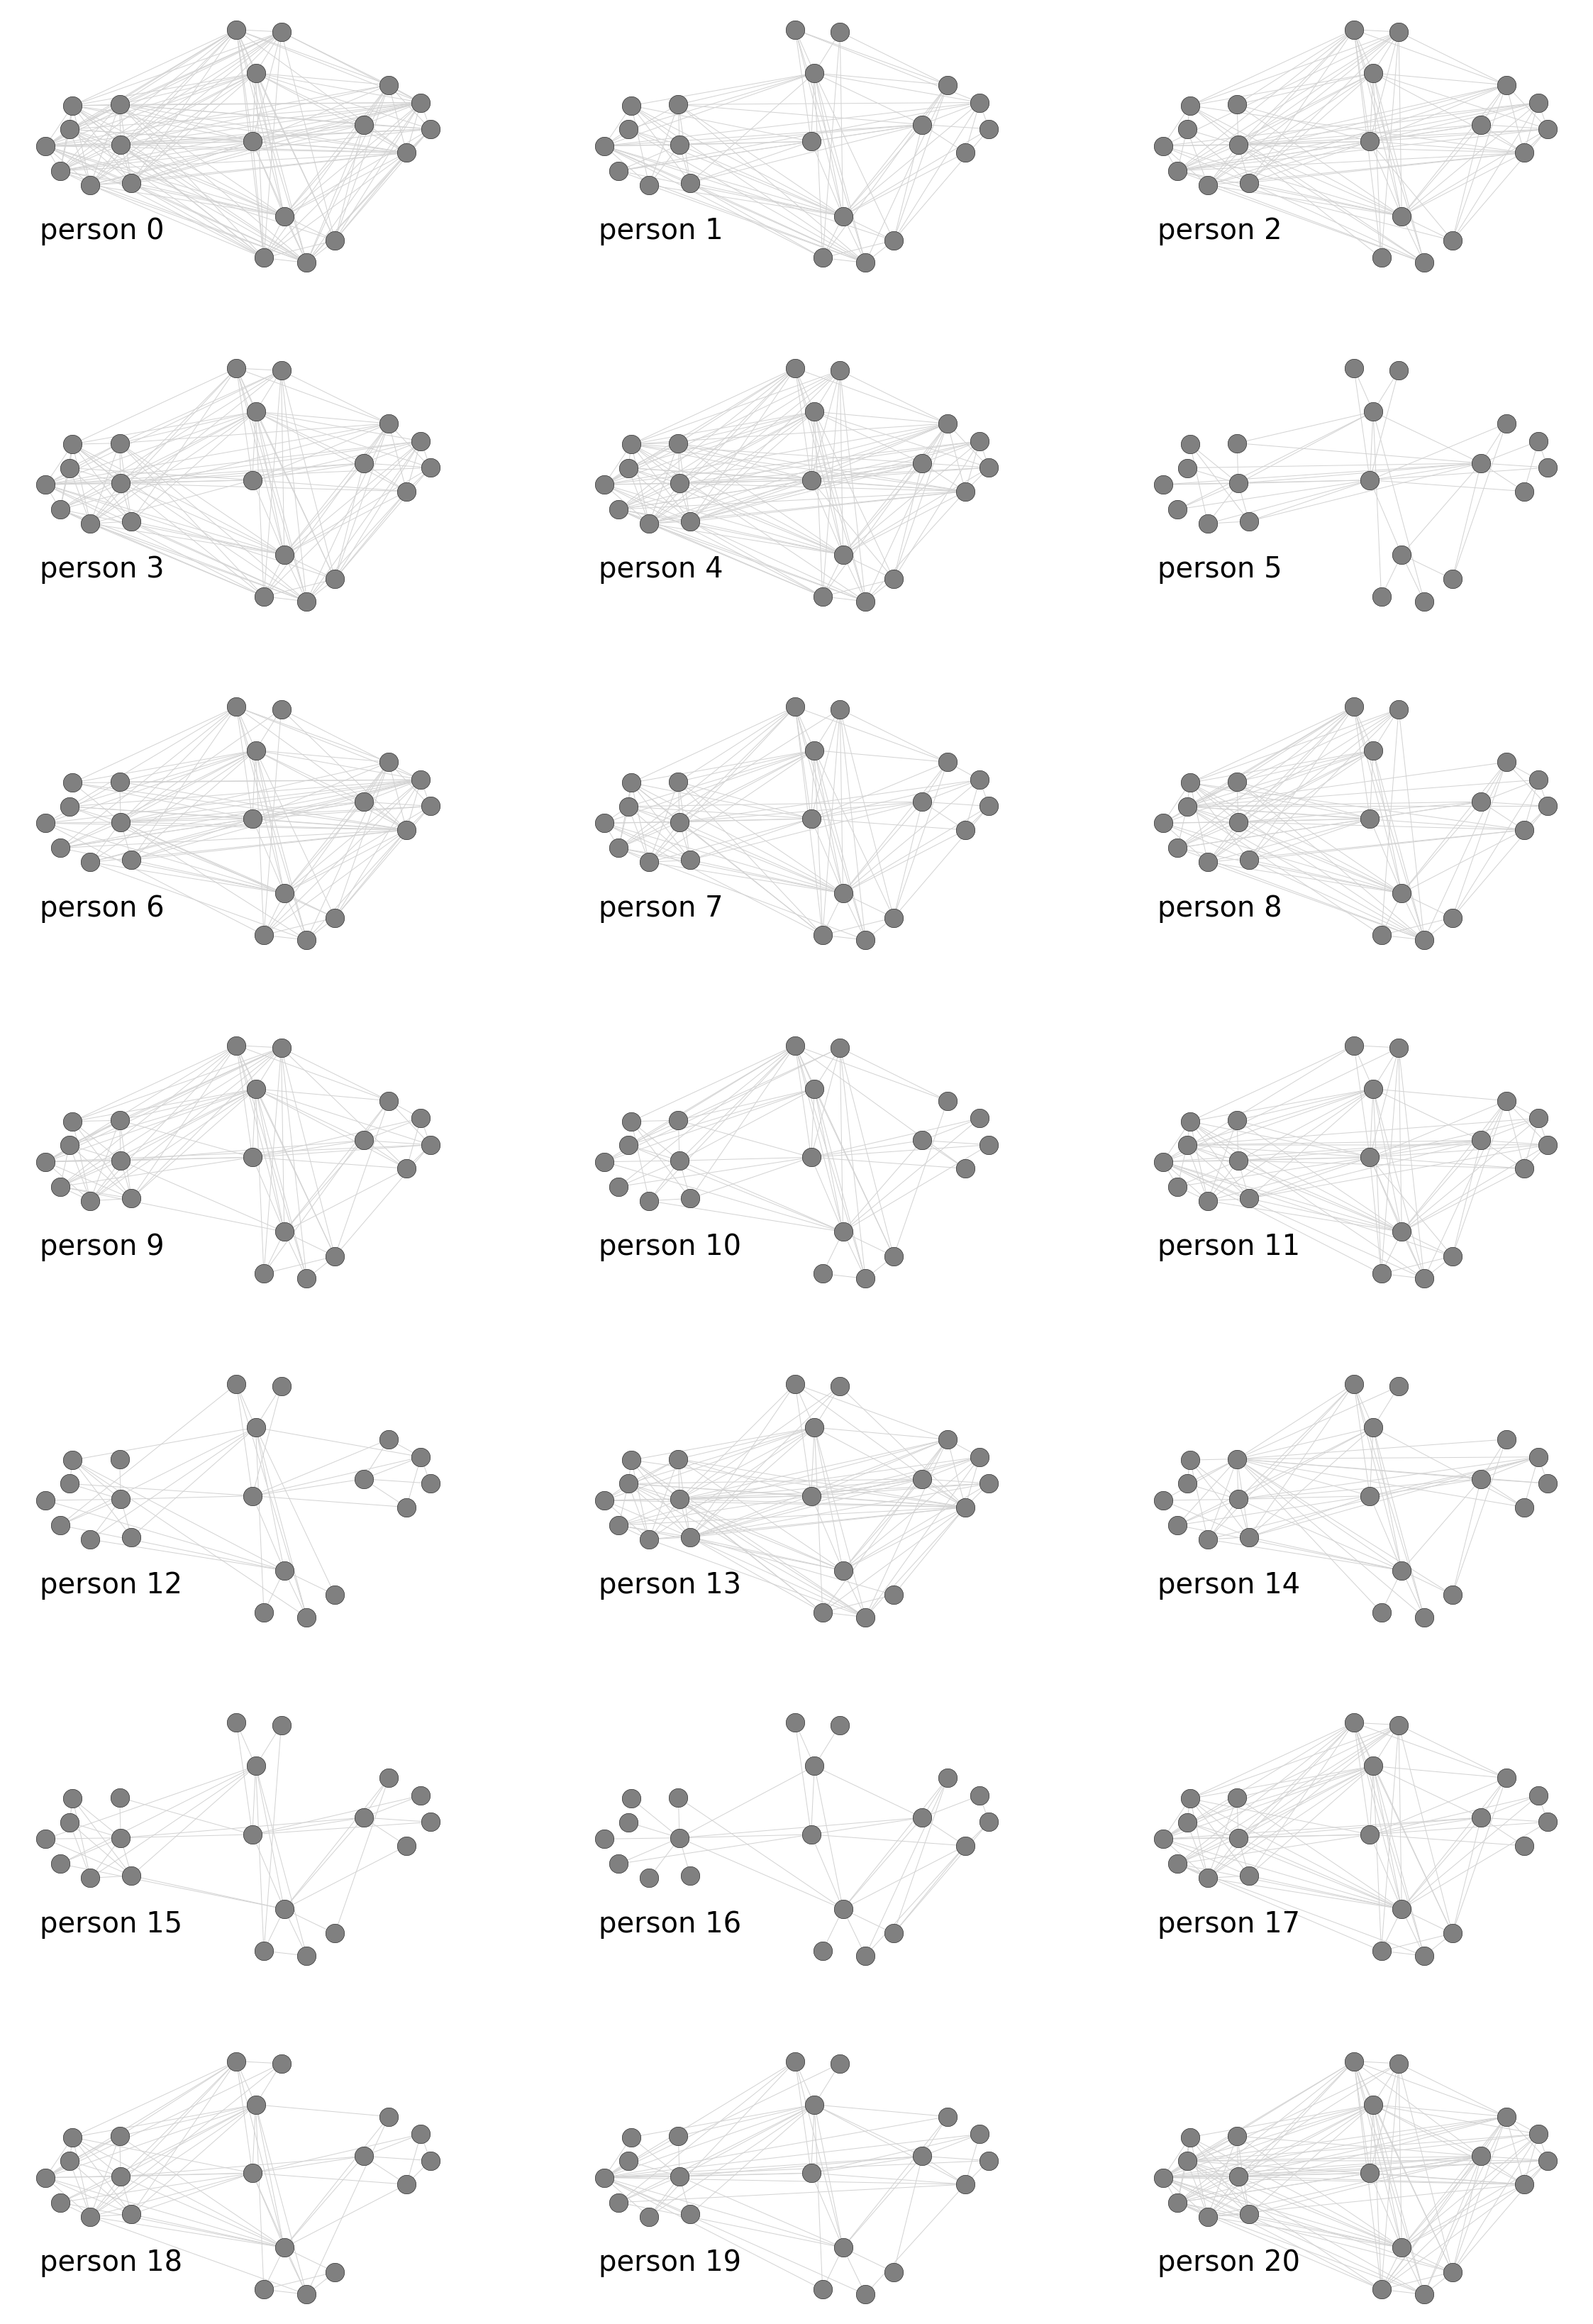

In [167]:
save_image = False
from matplotlib import cm
import networkx as nx
ALPHA, N, N = np.shape(krack)
tensor_Network = nx.from_numpy_array(krack[0])
rows = int(np.ceil(ALPHA/3))
f, axis = plt.subplots(rows, 3, figsize=(40,60))
r = 0; c = 0;
for l in range(ALPHA):
    tensor_Network = nx.from_numpy_array(krack[l])
    nx.draw(tensor_Network, posrep, ax = axis[r, c], node_color='grey', node_size=700, edge_color='lightgrey', with_labels=False)
    ax = plt.gca() # to get the current axis
    axis[r, c].collections[0].set_edgecolor("k") 
    axis[r, c].collections[0].set_linewidths(0.5) 
    axis[r,c].text(-1, -0.7, 'person {}'.format(l), fontsize = 40, c = 'k')
    if c < 2:
        c+=1
    else:
        c = 0
        r+=1
    

## Aggregations of the CSS
As we can see, visualizing all perceptions of the network separately can be a little overwhelming. Krackhardt (1987) proposed different aggregations of the CSS, including three types of Locally Aggregated Structures (LAS) and a Consensus Structure (CS). The "intersection" LAS is the logical ``AND`` of all of the perceived networks, the "union" LAS is the logical ``OR`` of all the perceived networks, and the "row dominated" LAS is the network that results from taking the $ith$ row from the $ith$ person's network perception. That is, for the row dominated LAS called $\boldsymbol{R}$, then $\boldsymbol{R}_{i,j}=\mathcal{A}_{i,j,i}$. The consensus structure is the aggregation of the CSS wherein an edge remains in the aggregation if at least some fraction $p$ of the people in the network perceive the edge. That is, for the consensus structure called $\boldsymbol{C}$, then $\boldsymbol{C}_{i,j}=1$ if $\frac{1}{N}\sum_k^N \mathcal{A}_{i,j,k} \geq p$. 

Below, we visualize the intersection LAS, the row dominated LAS, and the Consensus Structure with $p = 0.5$.

In [168]:
krack_las = np.zeros((21,21))
for i in range(21):
    for j in range(21):
        krack_las[i, j]= krack[i, i, j]
krack_and = np.sum(krack, axis = 0)
krack_and[np.where(krack_and < 1)] = 0
krack_and[np.where(krack_and >= 1)] = 1

krack_CS = np.sum(krack, axis = 0)
krack_CS[np.where(krack_CS < 10.5)] = 0
krack_CS[np.where(krack_CS >= 10.5)] = 1

Text(-1.5, -0.8, 'Consensus Structure')

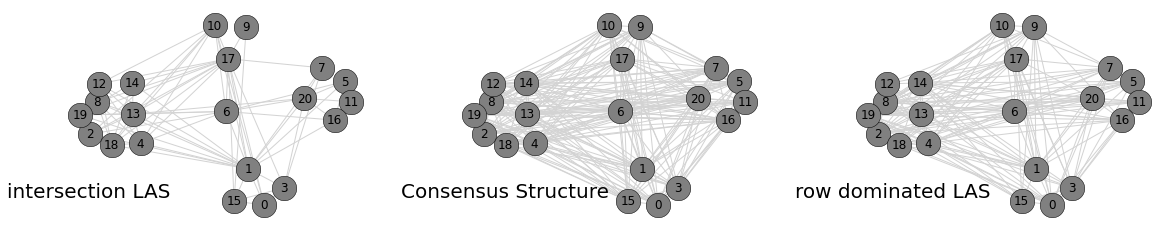

In [171]:
f, axis = plt.subplots(1,3)
f.set_figheight(4)
f.set_figwidth(20)

krack_and_net = nx.from_numpy_array(krack_and)
krack_cs_net = nx.from_numpy_array(krack_CS)
krack_las_net = nx.from_numpy_array(krack_las)

nx.draw(krack_and_net, posrep,  ax=axis[1], node_color='grey', node_size=600, edge_color='lightgrey', with_labels=True)
axis[1].collections[0].set_edgecolor("k") 
axis[1].collections[0].set_linewidths(0.5)

nx.draw(krack_cs_net, posrep,  ax=axis[0], node_color='grey', node_size=600, edge_color='lightgrey', with_labels=True)
axis[0].collections[0].set_edgecolor("k") 
axis[0].collections[0].set_linewidths(0.5)

nx.draw(krack_las_net, posrep,  ax=axis[2], node_color='grey', node_size=600, edge_color='lightgrey', with_labels=True)
axis[2].collections[0].set_edgecolor("k") 
axis[2].collections[0].set_linewidths(0.5)

axis[0].text(-1.5, -0.8, 'intersection LAS', fontsize = 20, c = 'k')
axis[2].text(-1.5, -0.8, 'row dominated LAS', fontsize = 20, c = 'k')
axis[1].text(-1.5, -0.8, 'Consensus Structure', fontsize = 20, c = 'k')


## Load the data to visualize hyperparameter sweep
We build different models of NNTucks for each dataset by sweeping over hyper-parameters $K$ and $C$, including with the constraint of $\boldsymbol{Y} = \vec{1}$ and $\boldsymbol{Y}=\boldsymbol{I}$. We evaluate each model in a fivefold cross-validation _tubular link prediction task_, wherein each of five different maskings of the data, 80\% of the data is visible and the remaining 20\% is misisng. In this setup, a missing edge between nodes $i$ and $j$ in layer $k$ implies that the edge between nodes $i$ and $j$ is missing in all layers. We plot the test-AUC as the AUC measured on the missing data, averaged across all five maskings. Code for finding random masking tensors which appropriately subset the data is in the `masking_tools_directed_chunks.py` file.

See Section X.X for more details.

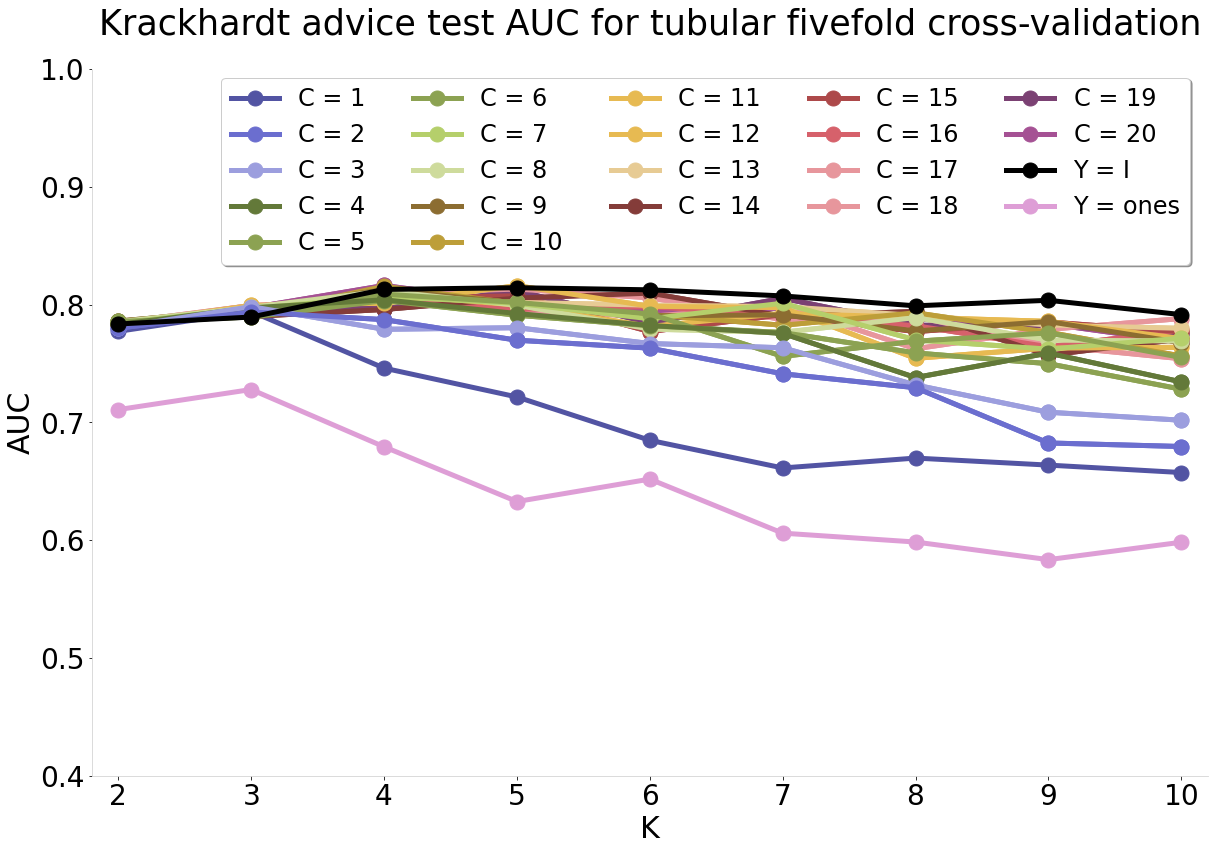

In [172]:
avg_AUCs_krack_chunka = np.load('avg_AUCs_krack_chunka.npy')
avg_krack_ones_AUCa_chunk = np.load('avg_krack_ones_AUCa_chunk.npy')

c_list = [1, 3, 6, 9, 12]
f, axis = plt.subplots(1,1)
f.set_figheight(13)
f.set_figwidth(20)
colormap = plt.cm.tab20b #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, 25)]
c_s = ['I', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
for ell in range(2,22):
    col = colors[ell]
    axis.plot(range(2,11),avg_AUCs_krack_chunka[:, ell-1], lw = 5, marker='o', markersize= 15, c=col, label = 'C = {}'.format(c_s[ell-1]))
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
    
for ell in range(21, 2, -1):
    col = colors[ell]
    axis.plot(range(2,11),avg_AUCs_krack_chunka[:, ell-1], lw = 5, marker='o', markersize= 15, c=col)
    #axis.hlines(avg_AUCs_Ala_iid[ell-2, 0], 1, 12, lw = 2, ls = 'dotted', color=col)
axis.plot(range(2,11),avg_AUCs_krack_chunka[:, 0], lw = 5, marker='o', markersize= 15, c='k', label = 'Y = {}'.format(c_s[0]))

    
axis.set_ylim(0.4, 1)
axis.set_xlim(1.8, 10.2)
axis.xaxis.set_major_locator(MaxNLocator(integer=True))
axis.plot(range(2,11), avg_krack_ones_AUCa_chunk, lw = 5, marker='o', markersize= 15, c=colors[-2], label = 'Y = ones')
#axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .95),
          #ncol=5, fancybox=True, shadow=True)
axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, 1.005),
          ncol=5, fancybox=True, shadow=True)
axis.set_xlabel('K', fontsize=30)
axis.set_ylabel('AUC', fontsize=30)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
axis.spines['bottom'].set_color('lightgrey')
axis.spines['top'].set_color('white')
axis.spines['left'].set_color('lightgrey')
axis.spines['right'].set_color('white')
axis.set_title('Krackhardt advice test AUC for tubular fivefold cross-validation',fontsize=35, pad=35)
# axis.legend(fontsize = 24, loc='upper center', bbox_to_anchor=(0.55, .995),
#           ncol=5, fancybox=True, shadow=True)
plt.savefig('kracka_chunk_sweep_legend.pdf', pad_inches=0.05)

We interpret the above plot by considering that the test-AUC for $K=C=3$ as a relatively good model-fit. We proceed with using these parameters to estimate an NNTuck.

## Estimating an NNTuck 

The following code definition is for estimating an NNTuck with multiple random initializations. The `multistart` function takes the following arguments:
- `tensor`: the adjacency matrix, in `numpy` format, of the CSS
- `C` and `K`: the values of $C$ and $K$, respectively.
- `masked`: either `True` or `False`, if the NNTuck should be estimated on a certain masking of the data
- `Mask`: either `None` or a `numpy` adjacency tensor of the same size as `tensor`.
- `Sym`: either `True` or `False`, depending on if the frontal slices of the adjacency tensor are undirected or directed, respectively.
- `NUM_IT`: integer value for how many random initializations to use for the NNTuck multiplicative updates algorithm.
-`ms_type`: one of `Ind, Red, SCA, reg`, depending on if the NNTuck to be estimated is Independent, Redundant, Social-Cognitive Agreement, or Regular, respectively. 

The function returns three arguments: `core`, `factors`, and `max_logl`, which are the core tensor, factor matrices, and log-likelihood associated with the NNTuck with the highest log-likelihood over the `NUM_IT` random initializations. `factors` is a list of size 3 with `factors[0]`, `factors[1]`, and `factors[2]` corresponding to the estimated $\boldsymbol{Y}, \boldsymbol{U},$ and $\boldsymbol{V}$, respectively. 

We'll use this function for estimating a particular NNTuck that we will analyse, as well as to estimate multiple NNTucks with different model assumptions, for use in our likelihood ratio tests.

In [182]:
def multistart(tensor, C, K, masked, Mask, Sym, NUM_IT, ms_type = 'reg'):
    if masked:
        assert np.shape(tensor) == np.shape(Mask), "size of tensor and Mask must be the same"
    if ms_type == 'Ind':
        return multi_nntuck_ind(tensor, C, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'Red':
        assert C == 1, "for a Redundant NNTuck, C must be equal to 1"
        return multi_nntuck_ones(tensor, C, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'SCA':
        assert C == K, "for a Redundant NNTuck, C must be equal to K"
        return multi_nntuck_sca(tensor, K, K, masked, Mask, Sym, NUM_IT)
    elif ms_type == 'reg':
        return multi_nntuck(tensor, C, K, masked, Mask, Sym, NUM_IT)
    else:
        print("ms_type must be one of: Ind, Red, SCA, reg")
        return
    
def multi_nntuck_ones(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker_ones(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker_ones(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]

    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck_ind(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker(tensor, rank = [ALPHA, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker(tensor, rank = [ALPHA, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=True, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]

    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
        
    tuck, logl, kld = non_negative_tucker(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=False, loss = 'KL', tol=10e-6)
    max_logl = logl[-1]
    max_tuck = tuck
    max_kld = kld[-1]

    for i in range(1, NUM_IT):
        tuck, logl, kld = non_negative_tucker(tensor, rank = [C, K, K], init='random', n_iter_max=1000,
                                                                 symmetric = Sym, masked = masked, Masking = Mask,
                                                          MT_stopping_conditions = True, returnErrors = True,
                                                            verbose=False, constrained=False, loss = 'KL', tol=10e-6)
        if logl[-1] > max_logl: 
            max_logl = logl[-1]
            max_tuck = tuck
            max_kld = kld[-1]
    
    core, factors = max_tuck
    return core, factors, max_logl

def multi_nntuck_sca(tensor, C, K, masked = False, Mask = None, Sym = False, NUM_IT = 20):
    ALPHA, N, N = np.shape(tensor)
    #C = K    
    tuck, logl, kld, kld_u, kld_min_ind = non_negative_tucker_SCagreement(tensor, rank = [K, K, K], init='random', n_iter_max=1000,
                                                             symmetric = False, masked = masked, Masking = Mask,
                                                                          socog = True,
                                                      MT_stopping_conditions = True, returnErrors = True,
                                                                              averaged = True,
                                                        verbose=False, constrained=False, loss = 'KL', tol=10e-8)
    max_logl = logl[kld_min_ind]
    max_tuck = tuck
    max_kld = kld[kld_min_ind]

    for i in range(1, NUM_IT):
        tuck, logl, kld, kld_u, kld_min_ind = non_negative_tucker_SCagreement(tensor, rank = [K, K, K], init='random', n_iter_max=1000,
                                                             symmetric = False, masked = masked, Masking = Mask,
                                                                              socog = True,
                                                      MT_stopping_conditions = True, returnErrors = True,
                                                                              averaged = True,
                                                        verbose=False, constrained=False, loss = 'KL', tol=10e-8)
        if logl[kld_min_ind] > max_logl: 
            max_logl = logl[kld_min_ind]
            max_tuck = tuck
            max_kld = kld[kld_min_ind]
    
    core, factors = max_tuck
    return core, factors, max_logl

## Likelihood Ratio Tests
The below function definitions are to perform both the standard LRT as well as the split-LRT from the Universal Inference (Wasserman et al., 2021) work. 

The `log_like` function takes the following arguments:
- `tensor`: the adjacency tensor, in `numpy` format, of the CSS
- `core`: an estimated core tensor from an NNTuck
- `factors`: a list of estimated factor matrices from an NNTuck. `factors` is a list of size 3 with `factors[0]`, `factors[1]`, and `factors[2]` corresponding to the estimated $\boldsymbol{Y}, \boldsymbol{U},$ and $\boldsymbol{V}$, respectively. 
- `masked`: either `True` or `False`, if the log-likelihood should only be measured over a certain masking of the data.
- `Mask`: either `None` or a `numpy` adjacency tensor of the same size as `tensor`.

The function returns `max_logl`, which is the log-likelihood associated with the provided `core` and `factors` from an NNTuck.

The `reg_LRT` function takes the following arguments:
- `tensor`: the adjacency tensor, in `numpy` format, of the CSS
- `C` and `K`: the values of $C$ and $K$, respectively.
- `M`: either `None` or a `numpy` adjacency tensor of the same size as `tensor`, indicating that the LRT should be measured over only a subset of the data.
- `R`: either `True` or `False` if the nested model to be tested is a redundant NNTuck.
- `Symmetric`: either `True` or `False`, depending on if the frontal slices of the adjacency tensor are undirected or directed, respectively.
- `SCA`: either `True` or `False`, depending on if the nested model to be tested is a Social-Cognitive Agreement NNTuck.
- `Ind`: either `True` or `False`, depending on if the full model to be tested is an Independent NNTuck.
- `alpha`: the significance level of the LRT.
The function returns `lrt_reg` and `reject`, where `lrt_reg` is the p-value associated with the LRT, and `reject` is `True` or `False`, whether or not the null hypothesis was rejected or not. 

The `masking_tensor_UI_LRT` function takes the argument:
- `tensor`: the adjacency tensor, in `numpy` format, of the CSS
The function returns `Maskings`, a two item list where `Maskings[0]` is a tensor of the same shape as `tensor`, where approximately half of the entries are valued `0` and the other half are valued `1`. `Maskings[1]` is the opposite tensor, where if `Maskings[0] = 0`, then `Maskings[1] = 1`, and if `Maskings[0] = 1`, then `Maskings[1] = 0`.

The `split_LRT` function takes the following arguments:
- `tensor`: the adjacency tensor, in `numpy` format, of the CSS
- `C` and `K`: the values of $C$ and $K$, respectively.
- `M`: a `numpy` adjacency tensor of the same size as `tensor`, which approximately splits the data in half for the split LRT. Should be either the `[0]` or `[1]` entry output of the `masking_tensor_UI_LRT` function.
- `R`: either `True` or `False` if the nested model to be tested is a redundant NNTuck.
- `Symmetric`: either `True` or `False`, depending on if the frontal slices of the adjacency tensor are undirected or directed, respectively.
- `SCA`: either `True` or `False`, depending on if the nested model to be tested is a Social-Cognitive Agreement NNTuck.
- `Ind`: either `True` or `False`, depending on if the full model to be tested is an Independent NNTuck.
- `alpha`: the significance level of the LRT.
The function returns `split_stat` and `reject`, where `split_stat` is the difference between the nested and full log-likelihoods evaluated on `M`, and `reject` is `True` or `False`, whether or not the null hypothesis was rejected or not. 

In [174]:
def log_like(tensor, core, factors, masked = False, M = None):
    # Returns the log-likelihood over just the observed entries (M = 1)
    B = tucker_to_tensor((core, factors), transpose_factors= False)
    if masked:
        B = M * B
    mask = B > 0
    return np.sum(np.where(mask, tensor*np.log(B, where=mask)-B, 0))

In [175]:
def reg_LRT(tensor, C, K, M = None, R = False, Symmetric = False, SCA = False, Ind = False, alpha = 0.05):
    # tensor is our multilayer network
    # M splits the data in two: M_0 (where M==0) and M_1, (where M==1)
    # K, C determine the latent dimensions of the nested model
    # Redundant = True if the nested model is the redundant NNTuck
    # Symmetric = True if the network is undirected
    # alpha is significance level for split LRT
    # need: core_0, factors_0, ll_0, the (ideally upper bounded) max likelihood estimat(e/ors) under the nested model
        # core_0, factors_0, and ll_0 are all from  nested model and only evaluated on/from M_0
    # need: core_1, factors_1, ll_1, any estimators under the full model and corr. log_likelihood
        # core_1, factors_1, and ll_1 are all from full model and only evaluated on/from M_1
        
    # core_0, factors_0 are the NNTuck(C,K) corresponding to the highest log-likelihood over 50 runs
    ALPHA, N, N = np.shape(tensor)
    L = ALPHA
    if Ind:
        ms_type_full = 'Ind'
        full_string = "Independent"
    else:
        ms_type_full = 'reg'
        full_string = "dependent with C = " + str(C) + ", K = " + str(K)
    if R:
        ms_type_nest = 'Red'
        nest_string = "Redundant"
    if SCA:
        ms_type_nest = 'SCA'
        nest_string = "social-cognitive agreement with K = C = "+ str(K)
    elif Ind and not R and not SCA:
        ms_type_nest = 'reg'
        nest_string = "dependent with C = " + str(C) + ", K = " + str(K)
        
    core_0, factors_0, ll_0 = multistart(tensor, C, K, masked = False, Mask = None, ms_type = ms_type_nest, 
                                         Sym = Symmetric, NUM_IT = 50)

    core_1, factors_1, ll_not1 = multistart(tensor, C, K, masked = False, Mask = None, 
                                            Sym = Symmetric, ms_type = ms_type_full, NUM_IT = 20)
    
    print("nested log like is {}, full log like is {}".format(ll_0,ll_not1))
    
    if SCA and Ind:
        deg = K*K*(N-K)
    elif SCA and not Ind:
        deg = L*C + K*K*C - K*K*K
    elif R and Ind:
        deg = (L-1)*K*K
    elif Ind and not R and not SCA:
        deg = (L-C)*K*K - L*C
        
    print("{} degrees of freedom \n".format(deg))
    LR_statistic = -2*(ll_0-ll_not1)
    #calculate p-value of test statistic using (L-1)K^2 degrees of freedom
    lrt_reg = scipy.stats.chi2.sf(LR_statistic, deg)
    print("the p value for the regular LRT is {}\n".format(lrt_reg))    
    if lrt_reg <= alpha:
        print("The LRT ({} <= {}) rejects the null: this network is {} at sig level alpha ".format(lrt_reg, alpha, full_string))
        reject = True
    else:
        print("The LRT ({} > {}) fails to reject the null: this network is {} at sig level alpha ".format(lrt_reg, alpha, nest_string))
        reject = False
    return lrt_reg, reject

In [176]:
def masking_tensor_UI_LRT(tensor): 
    # This function returns a masking tensor for a **directed** network (e.g., M == M.T)
        # here, M_ijk == 0 means that A_ijk is _unobserved_ 
        # In each of the M's with uniform probability a 
        # random set of ~50% of the entries are unobserved
        # here if M_ijk is unobserved, so is M_jik
        
    M_1 = np.ones_like(tensor)
    M_2 = np.ones_like(tensor)
    
    ALPHA, N, N = np.shape(tensor)
    M_fold = np.random.rand(ALPHA, N, N)

    M_1[np.where(np.logical_and(np.triu(M_fold) <= 0.5, np.triu(M_fold) > 0.0))] = 0
    a=np.where(M_1 == 0)
    b = tuple((a[0], a[2], a[1]))
    M_1[b] = 0

    M_2[np.where(np.logical_and(np.triu(M_fold) <= 1, np.triu(M_fold) > 0.5))] = 0
    a=np.where(M_2 == 0)
    b = tuple((a[0], a[2], a[1]))
    M_2[b] = 0

    Maskings = [M_1, M_2]
    return Maskings

In [177]:
def split_LRT(tensor, C, K, M, R = False, Symmetric = False, SCA = False, Ind = False, alpha = 0.05):
    # tensor is our multilayer network
    # M splits the data in two: M_0 (where M==0) and M_1, (where M==1)
    # K, C determine the latent dimensions of the nested model
    # Redundant = True if the nested model is the redundant NNTuck
    # Symmetric = True if the network is undirected
    # alpha is significance level for split LRT
    # need: core_0, factors_0, ll_0, the (ideally upper bounded) max likelihood estimat(e/ors) under the nested model
        # core_0, factors_0, and ll_0 are all from  nested model and only evaluated on/from M_0
    # need: core_1, factors_1, ll_1, any estimators under the full model and corr. log_likelihood
        # core_1, factors_1, and ll_1 are all from full model and only evaluated on/from M_1
        
    # core_0, factors_0 are the NNTuck(C,K) corresponding to the highest log-likelihood over 50 runs
    ALPHA, N, N = np.shape(tensor)
    L = ALPHA
    M0 = np.ones_like(M) - M
    
    if Ind:
        ms_type_full = 'Ind'
        full_string = "Independent"
    else:
        ms_type_full = 'reg'
        full_string = "dependent with C = " + str(C) + ", K = " + str(K)
    if R:
        ms_type_nest = 'Red'
        nest_string = "Redundant"
    if SCA:
        ms_type_nest = 'SCA'
        nest_string = "social-cognitive agreement with K = C = "+ str(K)
    elif Ind and not R and not SCA:
        ms_type_nest = 'reg'
        nest_string = "dependent with C = " + str(C) + ", K = " + str(K)
    
    core_0, factors_0, ll_0 = multistart(tensor, C, K, masked = True, Mask = M0, ms_type = ms_type_nest, 
                                         Sym = Symmetric, NUM_IT = 50)

    core_1, factors_1, ll_not1 = multistart(tensor, C, K, masked = True, Mask = M, 
                                            ms_type = ms_type_full, Sym = Symmetric, NUM_IT = 20)
    
    # ll_1 is the corresponding log likelihood, but evaluated only on M0
    ll_1 = log_like(tensor, core_1, factors_1, masked = True, M = M0)
    split_sig = np.log(1/alpha)
    split_stat = ll_1 - ll_0
      
    if split_stat >= split_sig:
        print("The split LRT ({} >= {}) rejects the null: this network is {} at sig level alpha ".format(split_stat, split_sig, full_string))
        reject = True
    else:
        print("The split LRT ({} < {}) fails to reject the null: this network is {} at sig level alpha ".format(split_stat, split_sig, nest_string))
        reject = False
    return split_stat, reject

### LRTs on Krackhardt Advice CSS

In [181]:
M0, M1 = masking_tensor_UI_LRT(krack)

#### Redundant v Independent, K=3

In [183]:
reg_LRT(krack, 1, 3, M = None, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -5299.636888263327, full log like is -4890.772159004494
180 degrees of freedom 

the p value for the regular LRT is 5.642067233592647e-82

The LRT (5.642067233592647e-82 <= 0.05) rejects the null: this network is Independent at sig level alpha 


(5.642067233592647e-82, True)

In [184]:
split_LRT(krack, 1, 3, M = M0, R = True, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-1189.982839449125 < 2.995732273553991) fails to reject the null: this network is Redundant at sig level alpha 


(-1189.982839449125, False)

#### Dependent v Independent, K=3, C = 3

In [185]:
reg_LRT(krack, 3, 3, M = None, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

nested log like is -4930.708381940756, full log like is -4875.61722259447
99 degrees of freedom 

the p value for the regular LRT is 0.20794527883978547

The LRT (0.20794527883978547 > 0.05) fails to reject the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(0.20794527883978547, False)

In [187]:
split_LRT(krack, 2, 3, M = M0, R = False, Symmetric = False, SCA = False, Ind = True, alpha = 0.05)

The split LRT (-816.031145514296 < 2.995732273553991) fails to reject the null: this network is dependent with C = 2, K = 3 at sig level alpha 


(-816.031145514296, False)

#### SCA K=C=3 vs Dependent K=3, C=3

In [193]:
reg_LRT(krack, 3, 3, M = None, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

nested log like is -5102.4255895179185, full log like is -4937.328384736781
63 degrees of freedom 

the p value for the regular LRT is 7.255255229653489e-38

The LRT (7.255255229653489e-38 <= 0.05) rejects the null: this network is dependent with C = 3, K = 3 at sig level alpha 


(7.255255229653489e-38, True)

In [194]:
split_LRT(krack, 3, 3, M0, R = False, Symmetric = False, SCA = True, Ind = False, alpha = 0.05)

The split LRT (-79.28469810672095 < 2.995732273553991) fails to reject the null: this network is social-cognitive agreement with K = C = 3 at sig level alpha 


(-79.28469810672095, False)

## NNTuck of the Krackhardt advice CSS with $K=C=3$
We use 50 random initializations of the multiplicative updates algorithm and examine the social and cognitive structure of the NNTuck corresponding to the highest log-likelihood over these random initializations. 

In [229]:
core, factors, loglike =  multistart(krack, 3, 3, masked = False, Mask = None, Sym = False, 
                                     NUM_IT = 50, ms_type = 'reg')

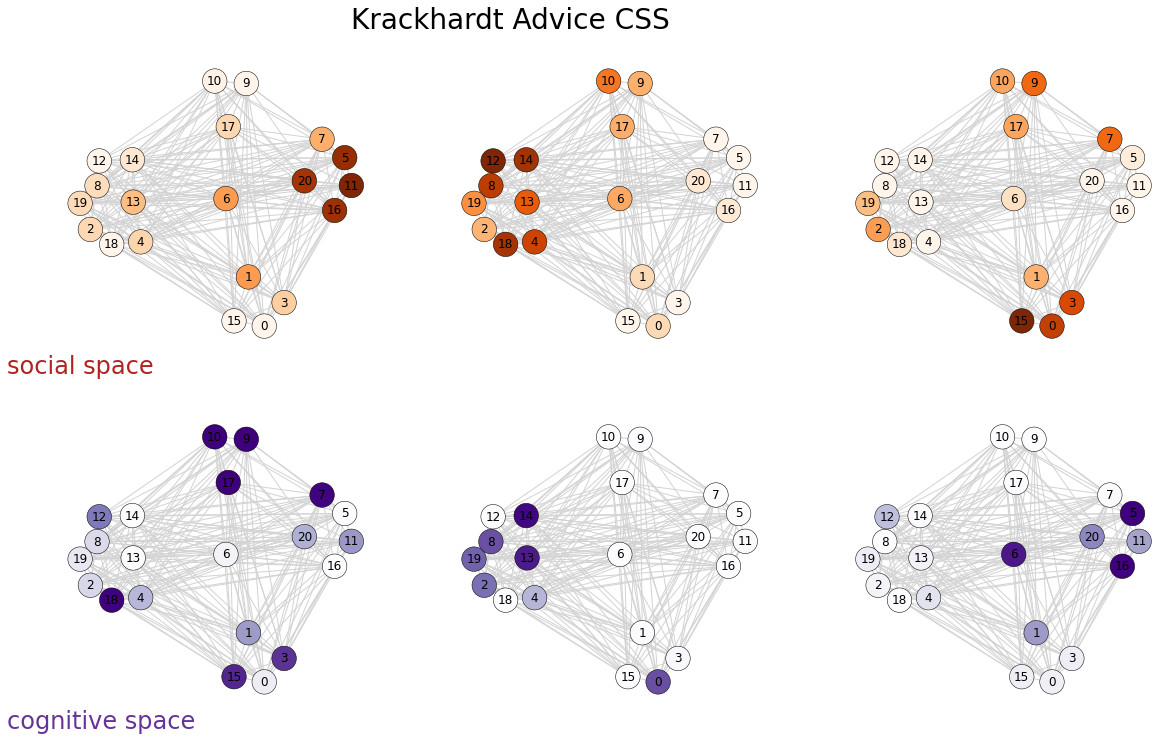

In [230]:
for n in range(1):
    f, axis = plt.subplots(2,3)
    f.set_figheight(12)
    f.set_figwidth(20)
    colors_U1 = ['c'] * len(krack_and)
    colors_U2 = ['c'] * len(krack_and)
    colors_U3 = ['c'] * len(krack_and)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    
    colors_cogsocdiff = ['c'] * len(krack_and)
#     two_core, two_factors = max_tuck
    Ytwo, Utwo, Vtwo = factors
    cmapOne=plt.get_cmap('Oranges')
    cmapTwo=plt.get_cmap('Purples')
    #Utwo = Us[n]
    #Ytwo = Ys[n]
    U_norm = Utwo/np.sum(Utwo, axis = 1, keepdims = True)
    Y_norm = Ytwo/np.sum(Ytwo, axis = 1, keepdims = True)
    for i in range(len(krack_and)):
        colors_U1[i] = cmapOne(U_norm[i, 0])
        colors_U2[i] = cmapOne(U_norm[i, 1])
        colors_U3[i] = cmapOne(U_norm[i, 2])
#         colors_U4[i] = cmapOne(U_norm[i, 3])
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])
#         colors_Y4[i] = cmapTwo(Y_norm[i, 3])
#         colors_Y5[i] = cmapTwo(Y_norm[i, 4])
        colors_cogsocdiff[i] = cmapOne(U_norm[i, 0]-Y_norm[i, 0])

    nx.draw(krack_and_net, posrep,  ax=axis[0,1], node_color=colors_U2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,1].collections[0].set_edgecolor("k") 
    axis[0,1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0,0], node_color=colors_U3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,0].collections[0].set_edgecolor("k") 
    axis[0,0].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0,2], node_color=colors_U1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0,2].collections[0].set_edgecolor("k") 
    axis[0,2].collections[0].set_linewidths(0.5)
#     nx.draw(krackf_Network, posrep,  ax=axis[0,3], node_color=colors_U4, node_size=600, edge_color='lightgrey', with_labels=True)
#     axis[0,3].collections[0].set_edgecolor("k") 
#     axis[0,3].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,1], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,1].collections[0].set_edgecolor("k") 
    axis[1,1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,2].collections[0].set_edgecolor("k") 
    axis[1,2].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[1,0], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1,0].collections[0].set_edgecolor("k") 
    axis[1,0].collections[0].set_linewidths(0.5)
#     nx.draw(krackf_Network, posrep,  ax=axis[1,3], node_color=colors_Y4, node_size=600, edge_color='lightgrey', with_labels=True)
#     axis[1,3].collections[0].set_edgecolor("k") 
#     axis[1,3].collections[0].set_linewidths(0.5)
    
#     nx.draw(krackf_Network, posrep,  ax=axis[1,4], node_color=colors_Y5, node_size=600, edge_color='lightgrey', with_labels=True)
#     axis[1,4].collections[0].set_edgecolor("k") 
#     axis[1,4].collections[0].set_linewidths(0.5)
    
    axis[0,0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 28, c = 'k')
    axis[0,0].text(-1.5, -1.2, 'social space', fontsize = 24, c = 'firebrick')
    axis[1,0].text(-1.5, -1.2, 'cognitive space', fontsize = 24, c = 'rebeccapurple')
    
    axis[1,2].axis('off')
    filename = 'kracka_cognet_max_3_3.pdf'
    plt.savefig(filename)
    #plt.close()

When constraining $K=C=3$, we see that the _social space_ of the firm can be mostly grouped according to departmental affiliation. We see that person 6 (the president), doesn't strongly belong to any of the three groups, whereas the three social groups mostly correspond to the left, bottom, and right, departmental groupings (visualized above in separate clusters). The exception to this is the departmental grouping that we view in the top, containing nodes 10, 9, and 17, which doesn't clearly belong to any of the three social groups.

The cognitive space, however, seems to group employees according to different attributes: those who perceive the network similarly to the president (person 6), to person 14, and everyone else. We see that persons 20, 5, and 16 belong mostly to the same cognitive space as the president, persons 13, 8, 19, and 0 belong mostly to the same cognitive space as person 14, and everyone else belongs to the third cognitive space. 

## Re-writing $\mathcal{G}$ in the basis of person 6, 14, and 11
The third factor matrix is more interpretable when we re-write the core tensor in the _basis_ of the affinity matrices for $C$ particular layers/people. When we do this, the $i$th frontal slice of the core tensor corresponds to the affinity matrix of the generative model that describes person $i$'s perception of the network. Rewriting $\mathcal{G}$ in this basis necessitates finding the corresponding relative $\boldsymbol{Y}^*$. The $i$th row of $\boldsymbol{Y}$ describes exactly how similar the generative model describing person $i$'s perception is to each of the $C$ basis models.

Choosing the basis layers can be done through contextual knowledge of the network, through inspection of the $\boldsymbol{Y}$ or the plotting of the cognitive space, or by inspecting $\left\Vert\boldsymbol{Y}\right\Vert_1$. The goal is to choose $C$ layers such that the row vectors $\boldsymbol{Y}_{b}$ for $b\in[1,C]$ are linearly independent. For example, considering the cognitive space plotted above, we would want to choose the darkest node in each of the three cognitive groups, because these three rows of $\boldsymbol{Y}$ will be far away from one another. 

For more details, see Appendix E of [Aguiar, Taylor, Ugander (2022)](https://arxiv.org/abs/2206.01804).

In [248]:
def Y_interp(factors, r_star = None, verbose = False):
    Y = factors[0]
    ALPHA, C = np.shape(Y)
    
    Y_star = np.zeros_like(Y)
    r_bar = [r for r in range(ALPHA) if r not in r_star]
    Y_rstar = Y[r_star, :]
    Y_rbar = Y[r_bar, :]
    Y_star[r_star, :] = np.eye(C)
    Y_star[r_bar, :] = np.linalg.solve(Y_rstar.T, Y_rbar.T).T
    
    if verbose:
        with np.printoptions(precision = 4, suppress=True):
            print("True Y is ")
            print("")
            print(Y)
            print("")
            print("Y_norm is")
            print("")
            print(Y/np.sum(Y, axis = 1, keepdims = True))
            print("")
            print("row normalized Y_star is")
            print("")
            print(Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True))
            print("")
                
    return Y_star/np.sum(abs(Y_star), axis = 1, keepdims = True)

In [250]:
Ystar = Y_interp(factors, r_star = [14, 6, 10], verbose = True)

True Y is 

[[0.0879 0.509  0.0759]
 [0.1082 0.     0.1086]
 [0.1135 0.2865 0.0324]
 [0.2887 0.0131 0.042 ]
 [0.1578 0.1619 0.0794]
 [0.     0.     0.1294]
 [0.0284 0.     0.3472]
 [0.2167 0.0001 0.0025]
 [0.0877 0.2648 0.0001]
 [0.2445 0.     0.    ]
 [0.1255 0.     0.    ]
 [0.1321 0.0046 0.12  ]
 [0.0579 0.     0.0335]
 [0.0018 0.3311 0.0289]
 [0.0014 0.2603 0.0043]
 [0.0735 0.     0.0098]
 [0.0005 0.     0.1062]
 [0.2343 0.0006 0.    ]
 [0.1705 0.001  0.    ]
 [0.034  0.1436 0.027 ]
 [0.1706 0.     0.2322]]

Y_norm is

[[0.1307 0.7565 0.1129]
 [0.4991 0.     0.5009]
 [0.2625 0.6626 0.0749]
 [0.8395 0.0382 0.1222]
 [0.3955 0.4057 0.1989]
 [0.     0.     1.    ]
 [0.0757 0.     0.9243]
 [0.9881 0.0006 0.0113]
 [0.2488 0.7511 0.0001]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [0.5146 0.0178 0.4676]
 [0.6337 0.     0.3663]
 [0.0051 0.915  0.0799]
 [0.0051 0.9788 0.0161]
 [0.8827 0.     0.1173]
 [0.0046 0.     0.9954]
 [0.9975 0.0025 0.    ]
 [0.9944 0.0056 0.    ]
 [0.1661 0.7019

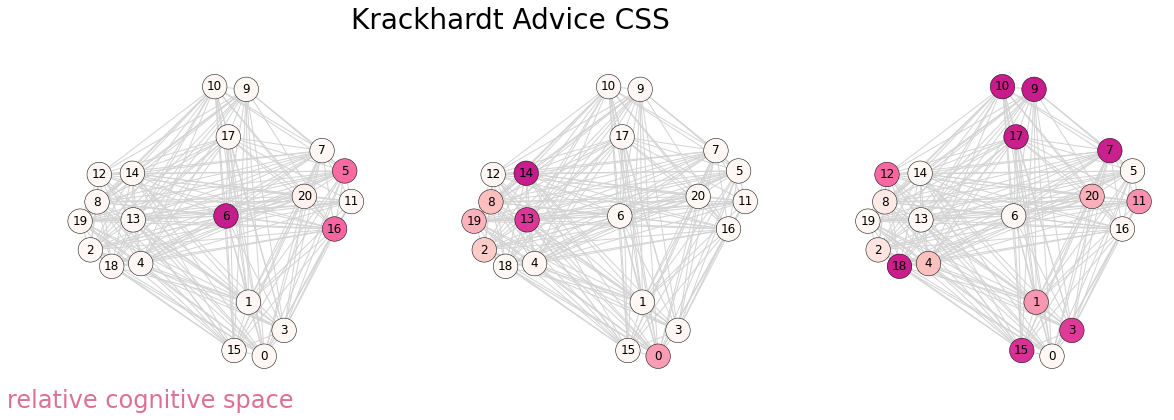

In [245]:
for n in range(1):
    f, axis = plt.subplots(1,3)
    f.set_figheight(6)
    f.set_figwidth(20)
    colors_Y1 = ['c'] * len(krack_and)
    colors_Y2 = ['c'] * len(krack_and)
    colors_Y3 = ['c'] * len(krack_and)
    cmapTwo=plt.get_cmap('RdPu')
    Y_norm = Ystar- 0.32*np.ones(3) # just to make the colour prettier 
    for i in range(len(krack_and)):
        colors_Y1[i] = cmapTwo(Y_norm[i, 0])
        colors_Y2[i] = cmapTwo(Y_norm[i, 1])
        colors_Y3[i] = cmapTwo(Y_norm[i, 2])

    nx.draw(krack_and_net, posrep,  ax=axis[1], node_color=colors_Y1, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[1].collections[0].set_edgecolor("k") 
    axis[1].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[2], node_color=colors_Y3, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[2].collections[0].set_edgecolor("k") 
    axis[2].collections[0].set_linewidths(0.5)
    nx.draw(krack_and_net, posrep,  ax=axis[0], node_color=colors_Y2, node_size=600, edge_color='lightgrey', with_labels=True)
    axis[0].collections[0].set_edgecolor("k") 
    axis[0].collections[0].set_linewidths(0.5)
    
    axis[0].text(1, 1.2, 'Krackhardt Advice CSS', fontsize = 28, c = 'k')
    axis[0].text(-1.5, -1.2, 'relative cognitive space', fontsize = 24, c = 'palevioletred')
    
    filename = 'kracka_cognet_rel_3_3.pdf'
    plt.savefig(filename)
    #plt.close()